CNN med Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# print(bhArray.shape)
# print(sphArray.shape)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

# np.shape(dataArray)

In [5]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

Sjekk om køyrer på GPU eller CPU

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

Her er vårt CNN modell

Her skal det komme endrigane for å tilpasse første CNN

In [11]:
#Define the ConvModel class
class ConvModel(nn.Module):
    #Constructor that initializes the layers of the model
    def __init__(self, dropout):

        super(ConvModel, self).__init__()
        #opprette conv lag. Bildene har 3 lag 
        
        #Dette funker ikke rør
        #Define convolutional layers for the input image
        #Input image has 3 challes, 3 layers
        #The first convolutional layer has 16 output channels and uses a kernel size of 3x3
        #ANd padding is set to 0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=0)
        #kanskje ha flere layers?

        #Unchange
        #Define fully connected layers
        #Input size to the first fully connected layer is 3*3*256
        #The first fully connected layer has 128 output units
        #The secon fully connected layer has 2 output units
        self.fc1 = nn.Linear(3*3*256, 128)
        self.fc2 = nn.Linear(128,2)

        #Define the dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)


    #Enten her eller over skal komme endringane for convolutional layer
    def forward(self, x:Tensor):
        
        #x = F.conv2d(x, self.conv1_filter, bias=self.conv1.bias, stride=1, padding=1)
        #Apply first conv layer
        x= self.conv1(x)
        #Apply relu activation function
        x = F.relu(x) 
        #Apply max pooling with a kernel size 2
        x = F.max_pool2d(x,2)
        #Apply the second conv layer
        x = self.conv2(x)
        #Apply relu activation function
        x = F.relu(x)
        #Apply max pooling with a kernel size of 2
        x = F.max_pool2d(x,2)
        #Apply the third conv layer
        x = self.conv3(x)
        #Apply relu activation function
        x = F.relu(x)
        #Appply max pooling with a kernel size 3
        x = F.max_pool2d(x,3)
        #Flatten the output of the conv layers
        x = torch.flatten(x, 1)
        
        #Apply the first fully connected layer
        x = self.fc1(x)
        #Apply relu activation function
        x = F.relu(x)
        x = self.dropout(x)
        #Apply teh second fully connected layer
        x = self.fc2(x)
        x = self.dropout(x)
        #Apply droput to layers??
        return x

summere modellen sine parametera

In [12]:
from torchsummary import summary

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2]               0
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


Trene modellen vår her, muligens implementere wandb her for å deploye modellen og se progressjonen og sammenligne med andre modeller samnt data agumentering kan komme med i denne delen av koden?

In [13]:
def train(model, train_loader, test_loader, optimizer, criterion, n_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #Create empty tabel that will be used to plot accuracy throughout epoch runs
    arr = []
        
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        
        correct = 0
        total = 0
        
        #Train loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2)).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        #Train loop end
        
        
        train_acc = 100 * correct / total
        train_loss /= len(train_loader)
        

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).long()
                outputs = model(inputs.permute(0, 3, 1, 2)).float()
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100 * correct / total
        test_loss /= len(test_loader)

        # Print results
        
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
        
        arr.append(train_acc)
    
    return arr    
        #PRInt grafisk din løk

Gjør kall på modellen

Epoch 1/15
Train Loss: 0.7668, Train Accuracy: 66.99%
Test Loss: 0.4384, Test Accuracy: 81.80%
Epoch 2/15
Train Loss: 0.5050, Train Accuracy: 72.92%
Test Loss: 0.4014, Test Accuracy: 83.87%
Epoch 3/15
Train Loss: 0.4607, Train Accuracy: 75.93%
Test Loss: 0.3382, Test Accuracy: 85.93%
Epoch 4/15
Train Loss: 0.4338, Train Accuracy: 77.00%
Test Loss: 0.3512, Test Accuracy: 86.04%
Epoch 5/15
Train Loss: 0.4223, Train Accuracy: 77.26%
Test Loss: 0.3836, Test Accuracy: 83.12%
Epoch 6/15
Train Loss: 0.4083, Train Accuracy: 78.30%
Test Loss: 0.3037, Test Accuracy: 87.79%
Epoch 7/15
Train Loss: 0.4013, Train Accuracy: 78.48%
Test Loss: 0.3270, Test Accuracy: 86.69%
Epoch 8/15
Train Loss: 0.3968, Train Accuracy: 79.06%
Test Loss: 0.2844, Test Accuracy: 88.15%
Epoch 9/15
Train Loss: 0.3907, Train Accuracy: 79.03%
Test Loss: 0.2922, Test Accuracy: 87.69%
Epoch 10/15
Train Loss: 0.3901, Train Accuracy: 79.39%
Test Loss: 0.2824, Test Accuracy: 88.35%
Epoch 11/15
Train Loss: 0.3708, Train Accuracy: 8

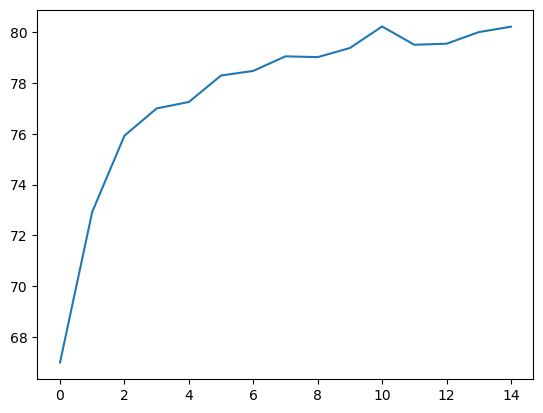

In [15]:
model = ConvModel(dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

tabell = train(model, trainLoader, testLoader, optimizer, criterion, n_epochs=15)

plt.plot(range(len(tabell)), tabell)
